# Graph-Based Image Segmentation using Normalized Cuts

This notebook implements the Normalized Cut (N-Cut) framework for image segmentation, covering:
- **(a)** Original vs. edge-aware affinity functions
- **(b)** Parameter analysis: varying σ_I and σ_X
- **(c)** Multi-way segmentation: recursive two-way N-Cut vs. simultaneous partitioning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import sparse
from scipy.sparse.linalg import eigsh
from skimage import data, color, filters, io, transform
from skimage.color import rgb2gray
from scipy.spatial.distance import cdist

All imports successful!


## Dataset Loading

We use built-in `skimage` images. Replace these with your own dataset images by loading them with `skimage.io.imread()` or `PIL`.

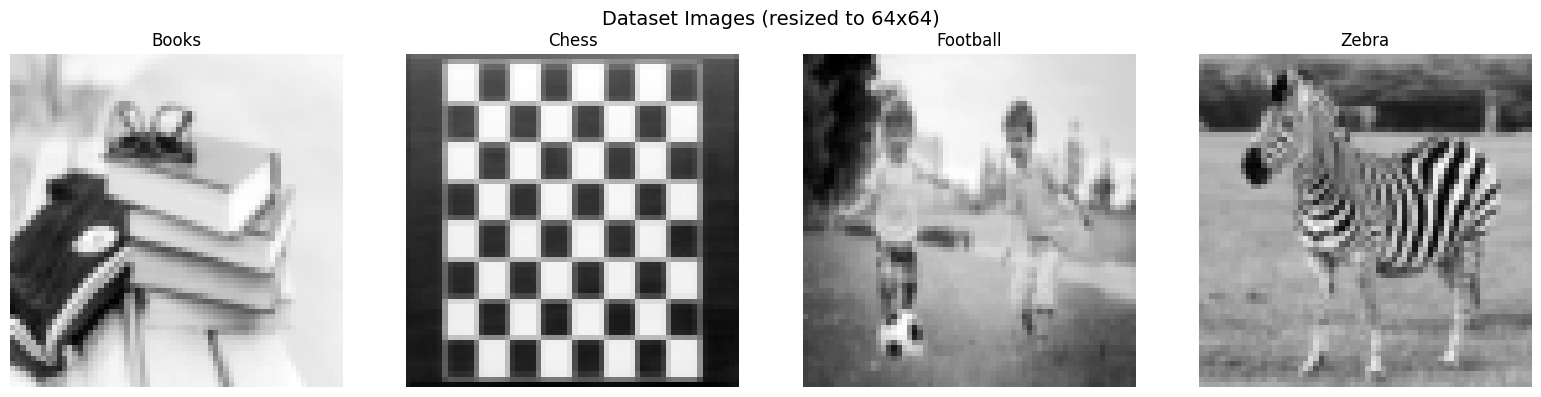

Dataset loaded: [(64, 64), (64, 64), (64, 64), (64, 64)]


In [3]:
def load_images():
    dataset_path = "../dataset/q1/"
    img1 = rgb2gray(io.imread(dataset_path + 'books.jpg'))
    img2 = rgb2gray(io.imread(dataset_path + 'chess.jpg'))
    img3 = rgb2gray(io.imread(dataset_path + 'football.jpg'))
    img4 = rgb2gray(io.imread(dataset_path + 'zebra.jpg'))

    # Resize to small size for faster computation (N-Cut is O(N^3))
    size = (64, 64)
    imgs = [
        transform.resize(img1, size, anti_aliasing=True),
        transform.resize(img2, size, anti_aliasing=True),
        transform.resize(img3, size, anti_aliasing=True),
        transform.resize(img4, size, anti_aliasing=True),
    ]
    names = ['Books', 'Chess', 'Football', 'Zebra']
    return imgs, names

images, image_names = load_images()

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, img, name in zip(axes, images, image_names):
    ax.imshow(img, cmap='gray')
    ax.set_title(name)
    ax.axis('off')
plt.suptitle('Dataset Images (resized to 64x64)', fontsize=14)
plt.tight_layout()
plt.savefig('../outputs/q1/dataset_images_resized.png', dpi=100)
plt.show()
print("Dataset loaded:", [img.shape for img in images])

## Core N-Cut Implementation

In [15]:
def build_pixel_features(image):
    """
    Build intensity and spatial location features for each pixel.
    Returns:
        I: (H*W,) array of pixel intensities
        X: (H*W, 2) array of normalized (row, col) spatial coordinates
    """
    H, W = image.shape

    # Intensity feature
    I = image.flatten()  # shape (N,)
    
    # Spatial features (normalized to [0,1])
    rows, cols = np.meshgrid(np.linspace(0, 1, H), np.linspace(0, 1, W), indexing='ij')
    X = np.stack([rows.flatten(), cols.flatten()], axis=1)  # (N, 2)
    
    return I, X


def compute_edge_strength(image):
    """
    Compute edge strength (gradient magnitude) between adjacent pixels.
    Uses Sobel filter to estimate gradient.
    Returns E: (H*W, H*W) sparse matrix of edge strengths between pixel pairs.
    """
    edges = filters.sobel(image)  # gradient magnitude
    return edges.flatten()  # (N,) edge strength at each pixel

In [ ]:
def build_affinity_matrix_original(image, sigma_I=0.1, sigma_X=0.1, radius=10):
    """
    Build the ORIGINAL affinity matrix:
        w_ij = exp(-||I(i)-I(j)||^2 / sigma_I^2) * exp(-||X(i)-X(j)||^2 / sigma_X^2)
    
    Uses a spatial radius to limit connections (sparse approximation).
    """
    H, W = image.shape
    N = H * W
    I, X = build_pixel_features(image)

    # ── Intensity term: exp(-||I(i)-I(j)||^2 / sigma_I^2) ──────────────
    # I shape: (N,)  →  diff_I shape: (N, N)
    diff_I = I[:, None] - I[None, :]          # broadcasting, (N, N)
    W_I = np.exp(-(diff_I ** 2) / sigma_I**2) # (N, N)

    # ── Spatial term: exp(-||X(i)-X(j)||^2 / sigma_X^2) ────────────────
    # X shape: (N, 2)  →  squared distances (N, N)
    diff_X = X[:, None, :] - X[None, :, :]    # (N, N, 2)
    dist_X_sq = np.sum(diff_X ** 2, axis=-1)  # (N, N)
    W_X = np.exp(-dist_X_sq / sigma_X**2)     # (N, N)

    # ── Combined affinity ───────────────────────────────────────────────
    W_dense = (W_I * W_X).astype(np.float32)
    np.fill_diagonal(W_dense, 0)              # no self-loops

    # Convert to sparse CSR for downstream eigensolver compatibility
    W_mat = sparse.csr_matrix(W_dense)
    return W_mat


In [30]:
def build_affinity_matrix_edge_aware(image, sigma_I=0.1, sigma_X=0.1, sigma_E=0.1, radius=10):

    """
    Build the MODIFIED (edge-aware) affinity matrix:

        w_ij = exp(-||I(i)-I(j)||^2 / sigma_I^2)
             * exp(-||X(i)-X(j)||^2 / sigma_X^2)
             * exp(-E_ij^2 / sigma_E^2)

    E_ij = average edge strength between pixels i and j.
    """

    H, W = image.shape
    N = H * W

    I, X = build_pixel_features(image)
    E = compute_edge_strength(image)   # shape (N,)

    # ── Intensity term ─────────────────────────────
    diff_I = I[:, None] - I[None, :]
    W_I = np.exp(-(diff_I ** 2) / sigma_I**2)

    # ── Spatial term ───────────────────────────────
    diff_X = X[:, None, :] - X[None, :, :]
    dist_X_sq = np.sum(diff_X ** 2, axis=-1)
    W_X = np.exp(-dist_X_sq / sigma_X**2)

    # ── Edge term ──────────────────────────────────
    E = E / (E.max() + 1e-8)
    
    E_ij = (E[:, None] + E[None, :]) / 2.0
    W_E = np.exp(-(E_ij ** 2) / sigma_E**2)

    # ── Combined affinity ─────────────────────────
    W_dense = (W_I * W_X * W_E).astype(np.float32)

    np.fill_diagonal(W_dense, 0)

    # # ── Optional: apply radius mask (same idea but vectorized)
    # coords = X
    # diff = coords[:, None, :] - coords[None, :, :]
    # dist_sq = np.sum(diff**2, axis=-1)
    # radius_mask = dist_sq <= radius**2

    # W_dense *= radius_mask

    # Convert to sparse CSR
    W_mat = sparse.csr_matrix(W_dense)

    return W_mat

In [31]:
def compute_ncut(W, n_segments=2):
    """
    Solve the Normalized Cut eigenproblem.
    Returns the n_segments smallest non-trivial eigenvectors.
    
    Generalized eigenproblem: (D - W) v = λ D v
    Equivalent to: D^{-1/2}(D-W)D^{-1/2} y = λ y
    """
    # Degree matrix
    d = np.array(W.sum(axis=1)).flatten()
    d = np.maximum(d, 1e-10)  # avoid division by zero
    D_inv_sqrt = sparse.diags(1.0 / np.sqrt(d))
    
    # Normalized Laplacian: L_sym = D^{-1/2}(D-W)D^{-1/2}
    D = sparse.diags(d)
    L = D - W
    L_sym = D_inv_sqrt @ L @ D_inv_sqrt
    
    # Compute n_segments+1 smallest eigenvalues (skip trivial λ=0)
    k = min(n_segments + 1, W.shape[0] - 2)
    eigenvalues, eigenvectors = eigsh(L_sym, k=k, which='SM', tol=1e-6, maxiter=1000)
    
    # Sort by eigenvalue
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Convert back: v = D^{-1/2} y
    eigenvectors = D_inv_sqrt @ eigenvectors
    
    return eigenvalues, eigenvectors


def threshold_eigenvector(v):
    """Threshold eigenvector at 0 for binary partition."""
    return (v >= 0).astype(int)


def ncut_two_way(W, image_shape):
    """
    Perform two-way N-Cut segmentation.
    Returns binary label map.
    """
    H, W_img = image_shape
    _, eigvecs = compute_ncut(W, n_segments=2)
    # Use 2nd smallest eigenvector (Fiedler vector)
    v2 = eigvecs[:, 1]
    labels = threshold_eigenvector(v2)
    return labels.reshape(H, W_img)

---
## Part (a): Original vs. Edge-Aware Affinity

Compare segmentation results using:
1. Original affinity: intensity + spatial terms
2. Modified edge-aware affinity: adds edge strength term E_ij

In [ ]:
SIGMA_I = 10 # 0.1
SIGMA_X = 15
SIGMA_E = 1
RADIUS  = 8

results_a = []

for img_idx in range(2):  # use first 2 images
    img = images[img_idx]
    name = image_names[img_idx]
    print(f"Processing '{name}'...")
    
    # Edge map for visualization
    edges = filters.sobel(img)
    
    print(f"  Building original affinity matrix...")
    W_orig = build_affinity_matrix_original(img, sigma_I=SIGMA_I, sigma_X=SIGMA_X, radius=RADIUS)
    
    print(f"  Building edge-aware affinity matrix...")
    W_edge = build_affinity_matrix_edge_aware(img, sigma_I=SIGMA_I, sigma_X=SIGMA_X, sigma_E=SIGMA_E, radius=RADIUS)
    
    print(f"  Running N-Cut (original)...")
    seg_orig = ncut_two_way(W_orig, img.shape)
    
    print(f"  Running N-Cut (edge-aware)...")
    seg_edge = ncut_two_way(W_edge, img.shape)
    
    results_a.append((img, edges, seg_orig, seg_edge, name))
    print(f"  Done.")

print("\nSegmentation complete.")

Processing 'Books'...
  Building original affinity matrix...
  Building edge-aware affinity matrix...
  Running N-Cut (original)...
  Running N-Cut (edge-aware)...
  Done.
Processing 'Chess'...
  Building original affinity matrix...
  Building edge-aware affinity matrix...
  Running N-Cut (original)...
  Running N-Cut (edge-aware)...
  Done.

Segmentation complete.


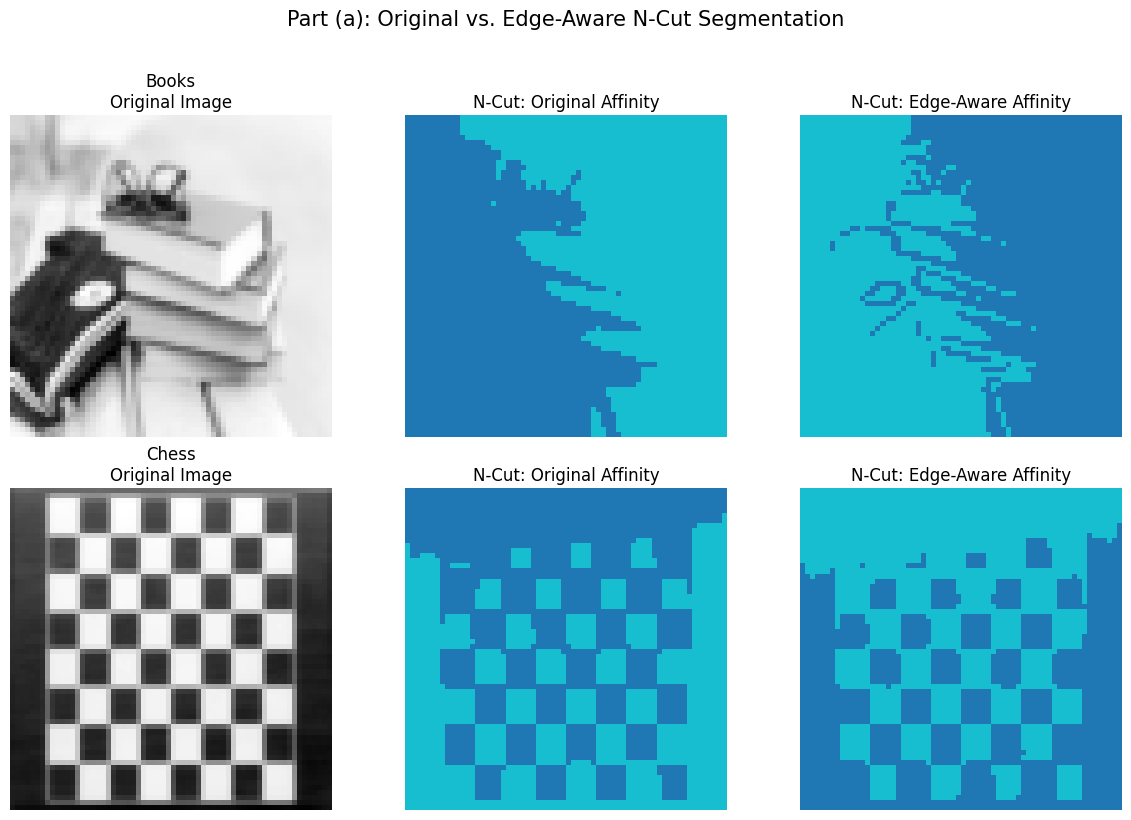

In [37]:
# Visualize Part (a) results
fig, axes = plt.subplots(len(results_a), 3, figsize=(12, 4 * len(results_a)))
if len(results_a) == 1:
    axes = axes[np.newaxis, :]

col_titles = ['Original Image', 'Seg: Original Affinity', 'Seg: Edge-Aware Affinity']

for row_idx, (img, edges, seg_orig, seg_edge, name) in enumerate(results_a):

    # --- Compute shared color scale for fair comparison ---
    min_label = min(seg_orig.min(), seg_edge.min())
    max_label = max(seg_orig.max(), seg_edge.max())

    # Original image
    axes[row_idx, 0].imshow(img, cmap='gray')
    axes[row_idx, 0].set_title(f'{name}\nOriginal Image')
    axes[row_idx, 0].axis('off')

    # Original segmentation
    axes[row_idx, 1].imshow(seg_orig, cmap='tab10', vmin=min_label, vmax=max_label)
    axes[row_idx, 1].set_title('N-Cut: Original Affinity')
    axes[row_idx, 1].axis('off')

    # Edge-aware segmentation (same colors)
    axes[row_idx, 2].imshow(seg_edge, cmap='tab10', vmin=min_label, vmax=max_label)
    axes[row_idx, 2].set_title('N-Cut: Edge-Aware Affinity')
    axes[row_idx, 2].axis('off')

plt.suptitle('Part (a): Original vs. Edge-Aware N-Cut Segmentation', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig('../outputs/q1/part_a_results.png', dpi=100, bbox_inches='tight')
plt.show()

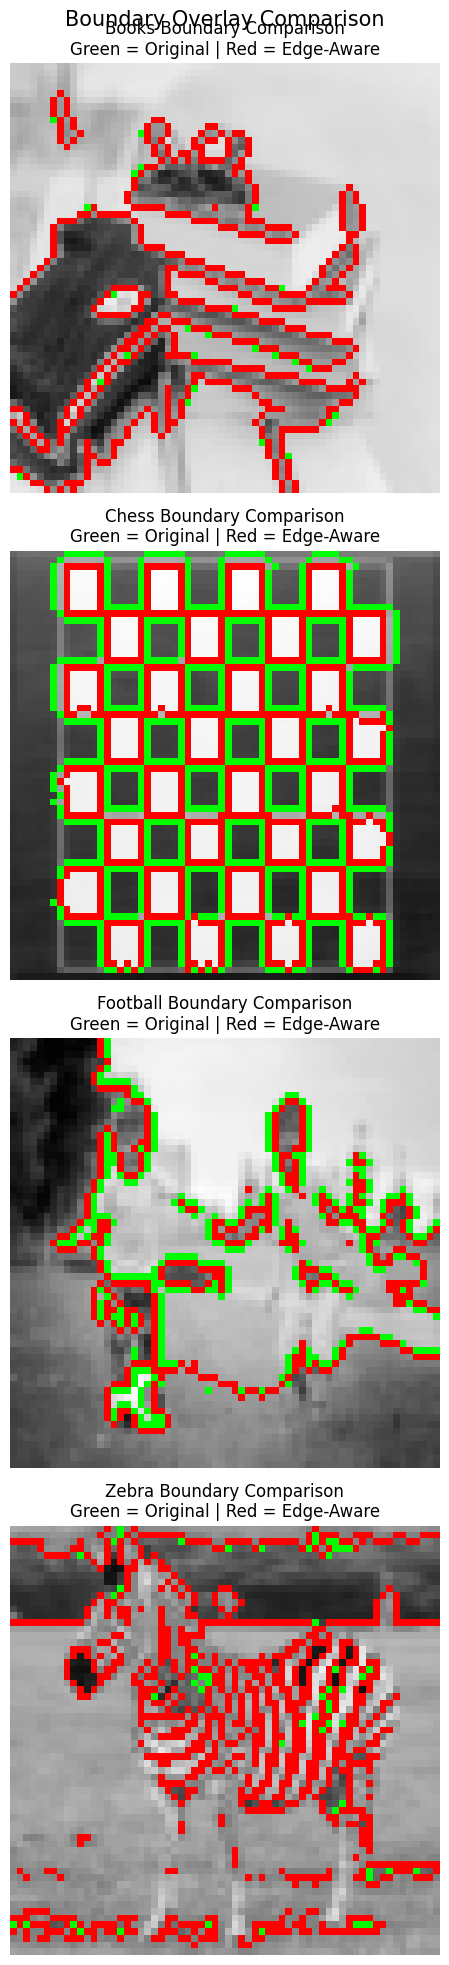

In [ ]:
# from skimage.segmentation import find_boundaries

# def get_boundary(seg):
#     return find_boundaries(seg, mode='outer')

# fig, axes = plt.subplots(len(results_a), 1, figsize=(6, 5 * len(results_a)))

# if len(results_a) == 1:
#     axes = [axes]

# for row_idx, (img, edges, seg_orig, seg_edge, name) in enumerate(results_a):

#     b_orig = get_boundary(seg_orig)
#     b_edge = get_boundary(seg_edge)

#     overlay = np.stack([img, img, img], axis=-1)

#     # Original boundary = GREEN
#     overlay[b_orig] = [0, 1, 0]

#     # Edge-aware boundary = RED
#     overlay[b_edge] = [1, 0, 0]

#     axes[row_idx].imshow(overlay)
#     axes[row_idx].set_title(f'{name} Boundary Comparison\nGreen = Original | Red = Edge-Aware')
#     axes[row_idx].axis('off')

# plt.suptitle('Boundary Overlay Comparison', fontsize=15)
# plt.tight_layout()
# plt.savefig('../outputs/q1/part_a_boundary_comparison.png', dpi=100, bbox_inches='tight')
# plt.show()

In [ ]:
# Part (a) Analysis
print("=" * 60)
print("PART (a) ANALYSIS")
print("=" * 60)
print("""
Original Affinity Function:
  w_ij = exp(-||I(i)-I(j)||^2 / σ_I^2) * exp(-||X(i)-X(j)||^2 / σ_X^2)

  - Connects pixels with similar intensities that are spatially close.
  - Does NOT explicitly model edges/boundaries.
  - May bleed across boundaries if intensity gradient is gradual.

Modified Edge-Aware Affinity:
  w_ij = exp(-||I(i)-I(j)||^2 / σ_I^2) 
       * exp(-||X(i)-X(j)||^2 / σ_X^2)
       * exp(-E_ij^2 / σ_E^2)

  - The extra exp(-E_ij^2/σ_E^2) term PENALIZES connections that
    cross strong edges (high gradient regions).
  - Pixels on opposite sides of a strong edge get very LOW affinity.
  - Results in sharper, more boundary-aligned segmentation.
  - Particularly effective near texture boundaries and sharp transitions.

Key Observations:
  - Edge-aware affinity produces regions that better respect structural
    boundaries in the image.
  - The original affinity may merge regions across soft gradient zones;
    edge-aware affinity separates them more cleanly.
  - σ_E controls boundary sensitivity: small σ_E = strict boundaries,
    large σ_E ≈ original affinity (edges have little effect).
""")

---
## Part (b): Parameter Analysis — σ_I and σ_X

In [34]:
# We'll use image 0 (Camera) for parameter analysis
img_b = images[0]

# --- Vary sigma_I while keeping sigma_X fixed ---
sigma_X_fixed = 15
sigma_I_values = [0.02, 0.1, 0.3, 0.6]

print(f"Varying σ_I with σ_X = {sigma_X_fixed} fixed...")
segs_vary_sigmaI = []
for sI in sigma_I_values:
    print(f"  σ_I = {sI}")
    W = build_affinity_matrix_original(img_b, sigma_I=sI, sigma_X=sigma_X_fixed, radius=RADIUS)
    seg = ncut_two_way(W, img_b.shape)
    segs_vary_sigmaI.append(seg)

# --- Vary sigma_X while keeping sigma_I fixed ---
sigma_I_fixed = 0.1
sigma_X_values = [5, 10, 15, 20]

print(f"\nVarying σ_X with σ_I = {sigma_I_fixed} fixed...")
segs_vary_sigmaX = []
for sX in sigma_X_values:
    print(f"  σ_X = {sX}")
    W = build_affinity_matrix_original(img_b, sigma_I=sigma_I_fixed, sigma_X=sX, radius=RADIUS)
    seg = ncut_two_way(W, img_b.shape)
    segs_vary_sigmaX.append(seg)

print("Done!")

Varying σ_I with σ_X = 15 fixed...
  σ_I = 0.02
  σ_I = 0.1
  σ_I = 0.3
  σ_I = 0.6

Varying σ_X with σ_I = 0.1 fixed...
  σ_X = 5
  σ_X = 10
  σ_X = 15
  σ_X = 20
Done!


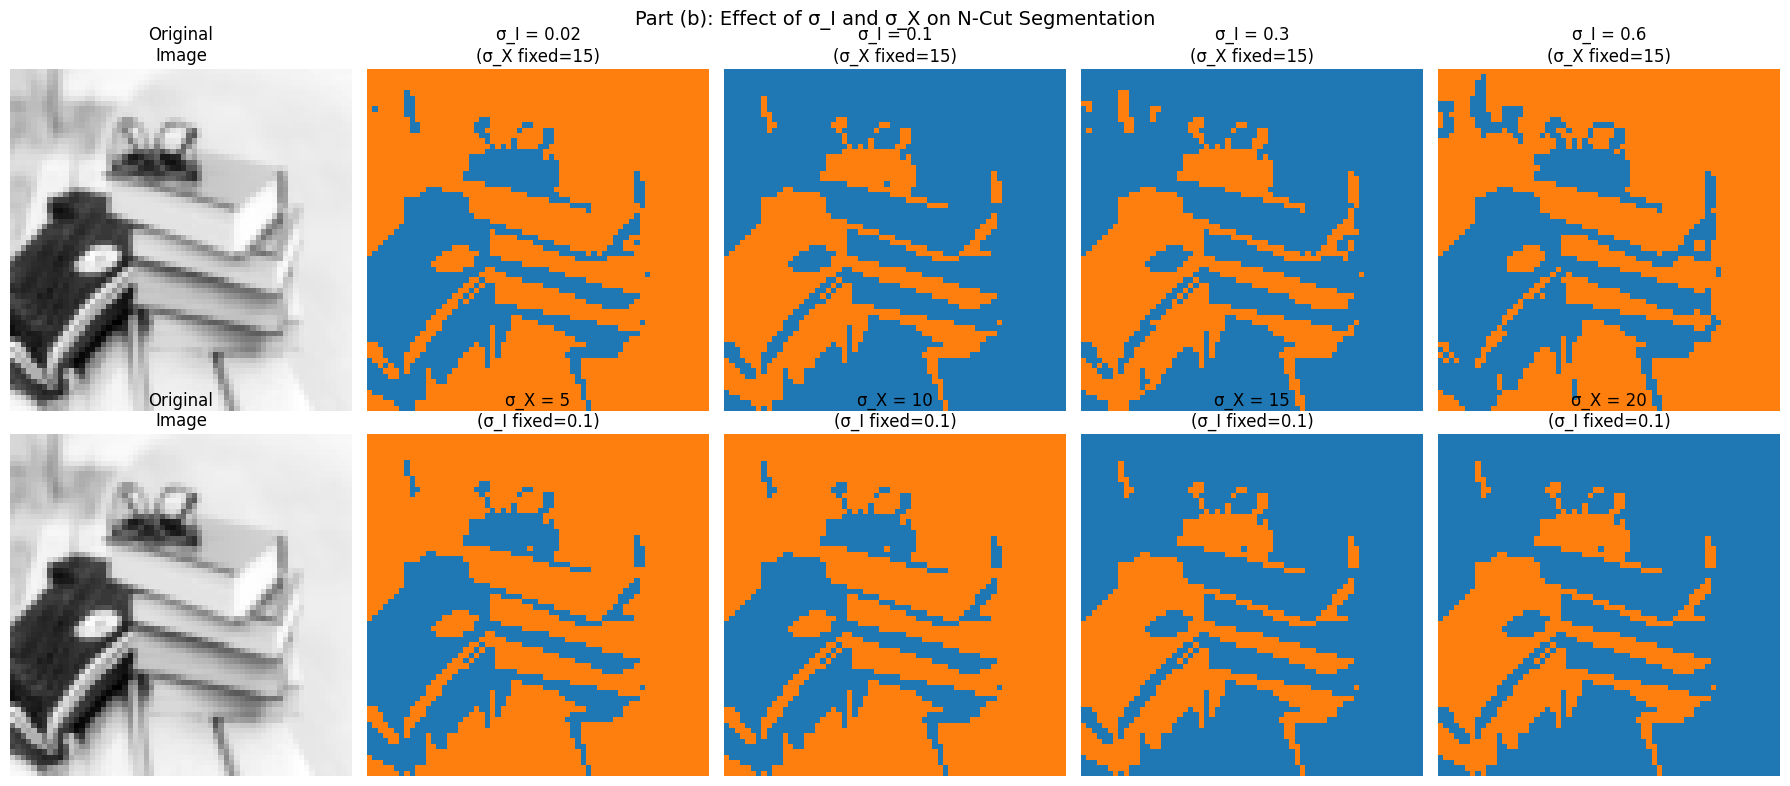

In [35]:
fig, axes = plt.subplots(2, len(sigma_I_values) + 1, figsize=(18, 8))

# Row 0: vary sigma_I
axes[0, 0].imshow(img_b, cmap='gray')
axes[0, 0].set_title('Original\nImage')
axes[0, 0].axis('off')
for j, (sI, seg) in enumerate(zip(sigma_I_values, segs_vary_sigmaI)):
    axes[0, j+1].imshow(seg, cmap='tab10', vmin=0, vmax=9)
    axes[0, j+1].set_title(f'σ_I = {sI}\n(σ_X fixed={sigma_X_fixed})')
    axes[0, j+1].axis('off')
axes[0, 0].set_ylabel('Varying σ_I', fontsize=12, rotation=90, labelpad=10)

# Row 1: vary sigma_X
axes[1, 0].imshow(img_b, cmap='gray')
axes[1, 0].set_title('Original\nImage')
axes[1, 0].axis('off')
for j, (sX, seg) in enumerate(zip(sigma_X_values, segs_vary_sigmaX)):
    axes[1, j+1].imshow(seg, cmap='tab10', vmin=0, vmax=9)
    axes[1, j+1].set_title(f'σ_X = {sX}\n(σ_I fixed={sigma_I_fixed})')
    axes[1, j+1].axis('off')
axes[1, 0].set_ylabel('Varying σ_X', fontsize=12, rotation=90, labelpad=10)

plt.suptitle('Part (b): Effect of σ_I and σ_X on N-Cut Segmentation', fontsize=14)
plt.tight_layout()
plt.savefig('part_b_results.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
print("=" * 60)
print("PART (b) ANALYSIS")
print("=" * 60)
print("""
Effect of varying σ_I (intensity bandwidth), with σ_X fixed:
──────────────────────────────────────────────────────────────
• Small σ_I (e.g., 0.02):
    - Only pixels with nearly IDENTICAL intensities are connected.
    - Leads to OVER-SEGMENTATION: small, fragmented regions.
    - Sensitive to noise; thin bright/dark textures are isolated.
    - Good for precise boundary localization.

• Large σ_I (e.g., 0.6):
    - Pixels with very different intensities are still strongly connected.
    - Intensity contrast has LITTLE EFFECT on affinity.
    - Leads to UNDER-SEGMENTATION: distinct objects may merge.
    - Boundary localization is poor — blobs are formed.

• Moderate σ_I (e.g., 0.1):
    - Balances contrast sensitivity and smoothness.
    - Provides good boundary localization without fragmentation.

Effect of varying σ_X (spatial bandwidth), with σ_I fixed:
──────────────────────────────────────────────────────────────
• Small σ_X (e.g., 0.05):
    - Only very nearby pixels are connected with significant weight.
    - Segmentation is driven primarily by LOCAL spatial neighborhoods.
    - OVER-SEGMENTATION: many small, spatially compact regions.
    - Boundaries are locally sharp but may not follow global structure.

• Large σ_X (e.g., 0.6):
    - Distant pixels can still have high affinity if similar in intensity.
    - Encourages GLOBALLY consistent regions (not just local patches).
    - UNDER-SEGMENTATION if σ_I is also large.
    - With moderate σ_I: tends to produce smoother, larger segments.

Summary — Impact on Segmentation Quality:
  σ_I: controls FEATURE (intensity) sensitivity
  σ_X: controls SPATIAL RANGE of pixel interaction
  Optimal choice depends on image content and desired granularity.
""")

---
## Part (c): Multi-way Segmentation

Two approaches:
1. **Recursive two-way N-Cut**: Apply binary N-Cut recursively on each sub-region
2. **Simultaneous partitioning**: Use multiple eigenvectors + K-means clustering

In [ ]:
from sklearn.cluster import KMeans


# ─────────────────────────────────────────────────────
# Approach 1: Recursive Two-Way N-Cut
# ─────────────────────────────────────────────────────

def compute_ncut_value(W, labels):
    """Compute the Normalized Cut value for a binary partition."""
    mask_A = labels == 1
    mask_B = labels == 0
    
    if mask_A.sum() == 0 or mask_B.sum() == 0:
        return 2.0  # degenerate case
    
    idx_A = np.where(mask_A)[0]
    idx_B = np.where(mask_B)[0]
    
    # Cut(A,B) = sum of weights between A and B
    W_sub = W[np.ix_(idx_A, idx_B)]
    cut_AB = W_sub.sum()
    
    # assoc(A, V) = sum of all weights from A
    assoc_A = W[idx_A, :].sum()
    assoc_B = W[idx_B, :].sum()
    
    if assoc_A < 1e-10 or assoc_B < 1e-10:
        return 2.0
    
    ncut = cut_AB / assoc_A + cut_AB / assoc_B
    return ncut


def recursive_ncut(image, n_segments, sigma_I=0.1, sigma_X=0.2, 
                   radius=8, ncut_threshold=1.0, depth=0, max_depth=10):
    """
    Recursively apply two-way N-Cut until we reach n_segments regions,
    or until the NCut value is above threshold (poor split).
    
    Returns: label map (H, W) with integer region labels.
    """
    H, W = image.shape
    N = H * W
    
    # Build affinity and segment
    W_mat = build_affinity_matrix_original(image, sigma_I=sigma_I, sigma_X=sigma_X, radius=radius)
    labels_flat = ncut_two_way(W_mat, image.shape).flatten()
    
    # Compute N-cut value to assess split quality
    ncut_val = compute_ncut_value(W_mat, labels_flat)
    
    result = np.zeros(N, dtype=int)
    
    # Process each of the two sub-regions
    for region_id in [0, 1]:
        region_mask = (labels_flat == region_id)
        region_pixels = np.where(region_mask)[0]
        
        if (n_segments <= 2 or 
            depth >= max_depth or 
            len(region_pixels) < 20 or
            ncut_val > ncut_threshold):
            # Assign same label to all pixels in this region
            result[region_mask] = region_id
        else:
            # Recurse into this region
            # Extract sub-image bounding box
            rows_in_region = region_pixels // W
            cols_in_region = region_pixels % W
            r_min, r_max = rows_in_region.min(), rows_in_region.max()
            c_min, c_max = cols_in_region.min(), cols_in_region.max()
            
            sub_img = image[r_min:r_max+1, c_min:c_max+1]
            
            if sub_img.shape[0] < 4 or sub_img.shape[1] < 4:
                result[region_mask] = region_id
                continue
            
            sub_labels = recursive_ncut(
                sub_img, n_segments=n_segments // 2,
                sigma_I=sigma_I, sigma_X=sigma_X, radius=radius,
                ncut_threshold=ncut_threshold,
                depth=depth + 1, max_depth=max_depth
            ).flatten()
            
            # Map sub-labels back — offset to avoid collision
            max_offset = result.max() + 1
            # Map each pixel in region to corresponding sub-label
            sub_H, sub_W = sub_img.shape
            for px_idx, px in enumerate(region_pixels):
                r, c = px // W, px % W
                sr, sc = r - r_min, c - c_min
                if 0 <= sr < sub_H and 0 <= sc < sub_W:
                    result[px] = sub_labels[sr * sub_W + sc] + max_offset
                else:
                    result[px] = max_offset
    
    # Re-index labels to be contiguous
    unique_labels = np.unique(result)
    label_map = {old: new for new, old in enumerate(unique_labels)}
    result = np.array([label_map[l] for l in result])
    
    return result.reshape(H, W)


print("Recursive N-Cut function defined.")

In [ ]:
# ─────────────────────────────────────────────────────
# Approach 2: Simultaneous Multi-way N-Cut (via k eigenvectors + k-means)
# ─────────────────────────────────────────────────────

def simultaneous_ncut(W, image_shape, n_segments=4, n_eigenvectors=None):
    """
    Perform simultaneous multi-way N-Cut.
    
    Algorithm:
    1. Compute k smallest eigenvectors of L_sym
    2. Stack eigenvectors as rows → embedding matrix Z ∈ R^{N x k}
    3. Normalize rows of Z to unit length
    4. Apply K-Means on rows of Z to get n_segments clusters
    
    Based on: Shi & Malik (2000) and Yu & Shi (2003)
    """
    H, W = image_shape
    
    if n_eigenvectors is None:
        n_eigenvectors = n_segments
    
    _, eigvecs = compute_ncut(W, n_segments=n_eigenvectors)
    
    # Use eigenvectors 1..k (skip trivial 0th)
    Z = eigvecs[:, 1:n_eigenvectors]  # shape (N, k-1)
    
    # Normalize rows to unit sphere (improves K-means clustering)
    norms = np.linalg.norm(Z, axis=1, keepdims=True)
    norms = np.maximum(norms, 1e-10)
    Z_normalized = Z / norms
    
    # K-Means clustering in eigenvector space
    kmeans = KMeans(n_clusters=n_segments, random_state=42, n_init=10)
    labels = kmeans.fit_predict(Z_normalized)
    
    return labels.reshape(H, W)


print("Simultaneous N-Cut function defined.")

In [ ]:
# Run multi-way segmentation on image 0 and image 1
N_SEGMENTS = 4

results_c = []

for img_idx in range(2):
    img = images[img_idx]
    name = image_names[img_idx]
    print(f"\nProcessing '{name}' with {N_SEGMENTS} segments...")
    
    # Build affinity once
    print("  Building affinity matrix...")
    W_mat = build_affinity_matrix_original(img, sigma_I=0.1, sigma_X=0.2, radius=RADIUS)
    
    # Method 1: Recursive
    print("  Running Recursive N-Cut...")
    seg_recursive = recursive_ncut(
        img, n_segments=N_SEGMENTS,
        sigma_I=0.1, sigma_X=0.2, radius=RADIUS,
        ncut_threshold=0.8, max_depth=3
    )
    
    # Method 2: Simultaneous
    print("  Running Simultaneous N-Cut...")
    seg_simultaneous = simultaneous_ncut(W_mat, img.shape, n_segments=N_SEGMENTS)
    
    results_c.append((img, seg_recursive, seg_simultaneous, name))
    n_rec = len(np.unique(seg_recursive))
    n_sim = len(np.unique(seg_simultaneous))
    print(f"  Recursive: {n_rec} regions | Simultaneous: {n_sim} regions")

In [ ]:
# Visualize Part (c) results
fig, axes = plt.subplots(len(results_c), 3, figsize=(14, 5 * len(results_c)))
if len(results_c) == 1:
    axes = axes[np.newaxis, :]

for row_idx, (img, seg_rec, seg_sim, name) in enumerate(results_c):
    axes[row_idx, 0].imshow(img, cmap='gray')
    axes[row_idx, 0].set_title(f'{name}\nOriginal')
    axes[row_idx, 0].axis('off')
    
    n_rec = len(np.unique(seg_rec))
    axes[row_idx, 1].imshow(seg_rec, cmap='tab10', vmin=0, vmax=9)
    axes[row_idx, 1].set_title(f'Recursive Two-Way N-Cut\n({n_rec} regions found)')
    axes[row_idx, 1].axis('off')
    
    n_sim = len(np.unique(seg_sim))
    axes[row_idx, 2].imshow(seg_sim, cmap='tab10', vmin=0, vmax=9)
    axes[row_idx, 2].set_title(f'Simultaneous (k eigenvectors + K-Means)\n({n_sim} regions)')
    axes[row_idx, 2].axis('off')

plt.suptitle(f'Part (c): Multi-Way N-Cut Segmentation (target: {N_SEGMENTS} segments)', fontsize=14)
plt.tight_layout()
plt.savefig('part_c_results.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# Visualize eigenvectors for simultaneous approach
img_demo = images[0]
W_demo = build_affinity_matrix_original(img_demo, sigma_I=0.1, sigma_X=0.2, radius=RADIUS)
_, eigvecs_demo = compute_ncut(W_demo, n_segments=6)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0, 0].imshow(img_demo, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

for i in range(1, min(8, eigvecs_demo.shape[1])):
    row, col = divmod(i, 4)
    if row < 2 and col < 4:
        v = eigvecs_demo[:, i].reshape(img_demo.shape)
        axes[row, col].imshow(v, cmap='RdBu_r')
        axes[row, col].set_title(f'Eigenvector {i}')
        axes[row, col].axis('off')

plt.suptitle('Eigenvectors of Normalized Laplacian\n(used in Simultaneous N-Cut)', fontsize=13)
plt.tight_layout()
plt.savefig('eigenvectors_visualization.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
print("=" * 60)
print("PART (c) ANALYSIS")
print("=" * 60)
print("""
Two Multi-Way Segmentation Strategies:
═══════════════════════════════════════

1. RECURSIVE TWO-WAY N-CUT
───────────────────────────
Algorithm:
  - Apply binary N-Cut to get 2 segments.
  - Recursively apply N-Cut within each segment.
  - Stop when: desired # segments reached OR N-cut value > threshold.

Strengths:
  ✓ Each split is an independent, well-posed binary N-Cut problem.
  ✓ Each cut is optimal at its level (locally optimal).
  ✓ Hierarchical structure allows threshold-based stopping.
  ✓ Can produce a dendrogram of regions.

Weaknesses:
  ✗ Early bad splits propagate — greedy and NOT globally optimal.
  ✗ Computationally expensive for many segments.
  ✗ Region sizes can be unbalanced.
  ✗ Sensitive to stopping criterion (ncut_threshold).

2. SIMULTANEOUS PARTITIONING (Multiple Eigenvectors + K-Means)
───────────────────────────────────────────────────────────────
Algorithm:
  - Compute k smallest eigenvectors of normalized Laplacian.
  - Embed each pixel in R^k using eigenvectors as coordinates.
  - Apply K-Means on normalized rows of embedding.

Strengths:
  ✓ Considers GLOBAL spectral information simultaneously.
  ✓ More consistent region assignment — avoids cascading errors.
  ✓ K-Means is fast after eigenvector computation.
  ✓ Number of segments K is directly controllable.
  ✓ Tends to produce more balanced, perceptually consistent regions.

Weaknesses:
  ✗ Requires computing multiple eigenvectors (expensive for large N).
  ✗ K-Means is sensitive to initialization (use multiple restarts).
  ✗ K-Means assumes isotropic clusters in eigenvector space.

Comparison:
────────────
  Perceptual Quality: Simultaneous ≥ Recursive (globally informed)
  Region Consistency: Simultaneous (no cascading greedy errors)
  Computational Cost: Recursive is cheaper for few segments
  Flexibility:        Recursive is easier to add hierarchy/stopping
  Recommended:        Simultaneous for fixed K; Recursive for hierarchical
""")

---
## Summary and Conclusions

In [ ]:
print("=" * 70)
print("COMPLETE SUMMARY")
print("=" * 70)
print("""
This notebook implemented the full Normalized Cut (N-Cut) framework.

Part (a) — Affinity Design:
  The edge-aware affinity adds an exp(-E_ij^2/σ_E^2) term that penalizes
  connections across edges. This improves boundary alignment, especially
  at strong gradients like object contours, textures, and depth edges.

Part (b) — Parameter Sensitivity:
  σ_I controls sensitivity to intensity differences:
    - Low → over-segmentation, high boundary accuracy
    - High → under-segmentation, smooth regions
  σ_X controls spatial connection range:
    - Low → local patches, many small regions
    - High → global grouping, larger uniform regions
  Ideal parameters must balance detail vs. coherence for the scene.

Part (c) — Multi-Way Segmentation:
  Recursive Two-Way N-Cut: simple, hierarchical, but greedy.
  Simultaneous (k eigenvectors + K-Means): globally consistent,
  better perceptual quality, preferred for fixed-K segmentation.

Implementation Notes:
  - Images are resized to 64×64 for tractability. For higher resolution
    images, use sparse approximate affinities (4-connectivity graph,
    small radius) and scalable eigensolver (ARPACK).
  - The scipy.sparse.linalg.eigsh solver is used for efficiency.
  - For production N-Cut, consider the skimage.future.graph module
    or specialized libraries like PyNcut, scikit-learn SpectralClustering.
""")